# Poacher detection - train YoloV3 model
-----

Let's train the YOLOV3 model using our training set of [drone image  from okutama](http://okutama-action.org/).

## Load packages

In [1]:
from core.model import (YOLOv3, decode, yolo_loss, load_weights)
from core import metrics
from core import utils
from core import config

import cv2
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
from tensorflow.keras import backend as K

from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import gc

In [2]:
print('tensorflow version:', tf.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.per_process_gpu_memory_fraction = 0.4

tensorflow version: 2.2.0-rc2


In [3]:
# import mlflow
# import mlflow.tensorflow
# print(mlflow.__version__)
# mlflow.set_experiment('poacher-detection-based-on-yolov3')
# mlflow.tensorflow.autolog()

## Create model

In [4]:
def load_model(model_path):
    
    metrics_poacher = [
        metrics.poacher_accuracy, 
        metrics.poacher_precision, 
        metrics.poacher_recall, 
        metrics.TP, 
        metrics.FP, 
        metrics.FN, 
        metrics.TN
    ]
    t0 = time.time()
    model = tf.keras.models.load_model(model_path, compile=False)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

    model.compile(optimizer=optimizer, 
                  loss={
                      'tf_op_layer_concat_4': lambda y_true, y_pred: yolo_loss(y_true, y_pred), # 52x52
                      'tf_op_layer_concat_7': lambda y_true, y_pred: yolo_loss(y_true, y_pred), # 26x26
                      'tf_op_layer_concat_10': lambda y_true, y_pred: yolo_loss(y_true, y_pred),# 13x13
                  }, metrics=metrics_poacher
                 )
    print('model loaded in %.2fs'%(time.time() - t0))
    return model

In [6]:
model_path = 'save/20200420_model_trained.h5'
model = load_model(model_path)

model loaded in 7.04s


**Original code to retrieve YOLOV3 model before training**

In [7]:
# K.clear_session()
# in_size = config.INPUT_SIZE
# input_layer  = tf.keras.layers.Input([in_size, in_size, 3])
# conv_tensors = YOLOv3(input_layer)

# bbox_tensors = []
# for i, conv_tensor in enumerate(conv_tensors):
#     bbox_tensor = decode(conv_tensor, i)
#     bbox_tensors.append(bbox_tensor)

# model = tf.keras.Model(input_layer, bbox_tensors)
# load_weights(model, "/data/model/yolov3.weights")

In [8]:
from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu (TensorFl (None, 416, 416, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
gc.collect()

1845

## Load labels & training frames

In [11]:
frames_dir = '/data/train/'
labels_path = '/data/train_labels.csv'

In [12]:
labels = utils.load_labels(labels_path)

In [13]:
labels.shape

(316435, 7)

In [14]:
# Get all frames from a directory
frames_list = os.listdir(frames_dir)
frames_list = [f for f in frames_list if '(' not in f]

frames = [frames_dir + f for f in frames_list]

In [15]:
frames[:2]

['/data/train/1.2.5_48.jpg', '/data/train/1.1.1_1931.jpg']

In [16]:
print('There are %i images in the training set'% len(frames))

There are 60040 images in the training set


## Check one image with true bboxes

Num person on frame: 8


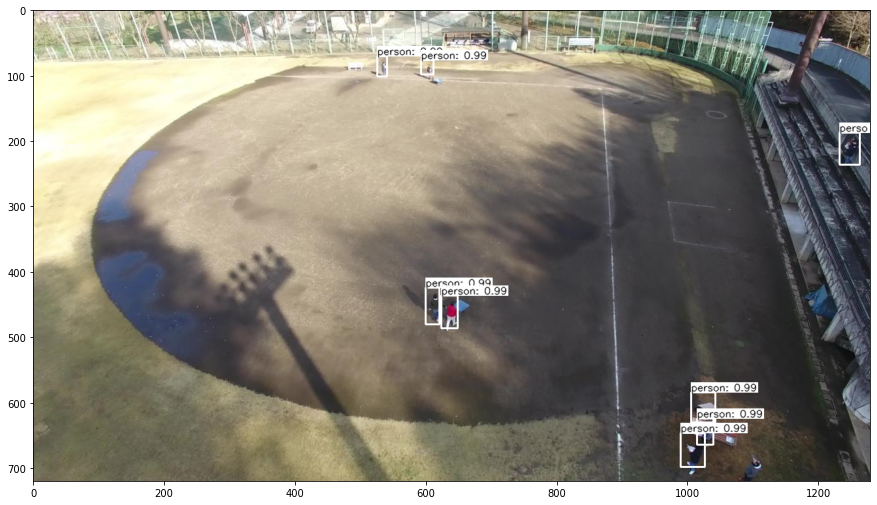

In [17]:
image_path = '/data/train/1.1.10_783.jpg'
res = utils.frame_with_true_bboxes(image_path, labels)
fig, ax = plt.subplots(figsize=(15,22))
plt.imshow(res)
plt.show()

## Same image with loaded model bboxes prediction

Num person detected: 1


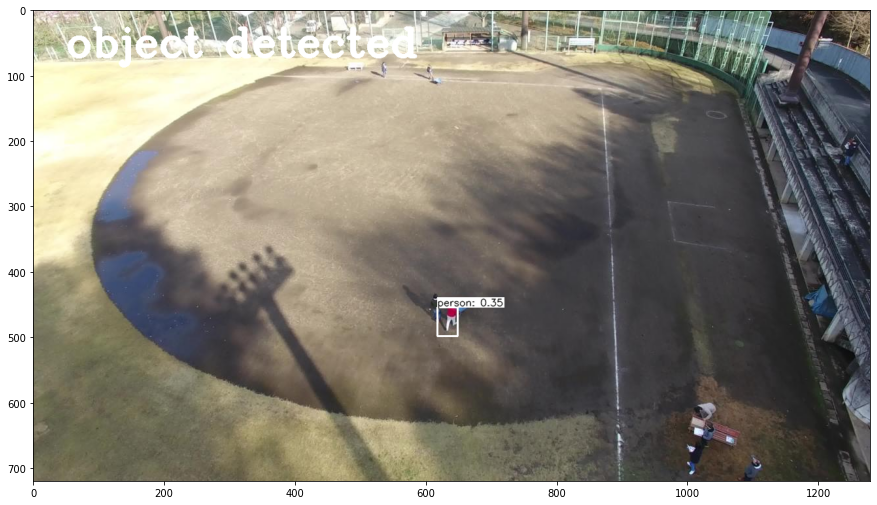

CPU times: user 1.2 s, sys: 15.9 ms, total: 1.22 s
Wall time: 1.2 s


In [19]:
%%time
frame = cv2.imread(image_path)
out_orig = utils.predict_on_frame(frame, model)
fig, ax = plt.subplots(figsize=(15,22))
plt.imshow(out_orig)
plt.show()

## Setup Tensorboad

In [20]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# before training init writer (for tensorboard log) / model
writer_train = tf.summary.create_file_writer(log_dir+'/train')
writer_valid = tf.summary.create_file_writer(log_dir+'/valid')

## Compile the model and add custom metrics

In [21]:
model.input

<tf.Tensor 'input_1_1:0' shape=(None, 416, 416, 3) dtype=float32>

In [22]:
model.output

[<tf.Tensor 'tf_op_layer_concat_4_1/Identity:0' shape=(None, None, None, None, None) dtype=float32>,
 <tf.Tensor 'tf_op_layer_concat_7_1/Identity:0' shape=(None, None, None, None, None) dtype=float32>,
 <tf.Tensor 'tf_op_layer_concat_10_1/Identity:0' shape=(None, None, None, None, None) dtype=float32>]

In [23]:
# # Choose optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# # Compile model
# model.compile(optimizer=optimizer, 
#               loss={
#                   'tf_op_layer_concat_4': lambda y_true, y_pred: yolo_loss(y_true, y_pred), # 52x52
#                   'tf_op_layer_concat_7': lambda y_true, y_pred: yolo_loss(y_true, y_pred), # 26x26
#                   'tf_op_layer_concat_10': lambda y_true, y_pred: yolo_loss(y_true, y_pred),# 13x13
#               }, metrics=[poacher_accuracy, poacher_recall, poacher_precision])#, TP, FP, FN, TN])

## Train

In [24]:
def load_batch_data(frames):
    """
    """
    n_batch = len(frames)

    Y_true = [np.zeros((n_batch, config.OUT_SIZE[i], config.OUT_SIZE[i], 3, (5+config.NUM_CLASS))) for i in range(3)]
    X = np.zeros(shape=(n_batch, config.INPUT_SIZE, config.INPUT_SIZE, 3), dtype=np.float32)

        
    for b in range(n_batch):
        image_data, image_target = utils.get_one_img_true_bboxes(frames[b], labels)

        X[b] = image_data

        for k in range(len(image_target)):
            Y_true[k][b] = image_target[k]

        gc.collect()
    
    return X, Y_true

def format_scores(scores):
    losses = np.mean(np.array(scores)[:,:4], axis=0)
    
    n = len(scores)
    scores_np = np.array(scores)[:,4:].reshape(n,3,-1)#.reshape(3,n,-1)
    l52 = scores_np[:,0]
    l26 = scores_np[:,1]
    l13 = scores_np[:,2]
    scores_np = np.array([l52, l26, l13])
    scores_np = np.round(np.nanmean(scores_np[:,:,:3], axis=1),2)
#     sum = np.round(np.nansum(scores_np[:,:,3:], axis=1))
#     scores_np = np.concatenate([avg, sum], axis=1)

    scores_df = pd.DataFrame(scores_np, 
                             columns=['accuracy','precision','recall'],#'TP','FP','FN','TN'],
                             index=['layer 52x52','layer 26x26','layer 13x13'])
    return losses, scores_df

def tensorboard_write_scores(writer, losses, scores, n_epoch):
    with writer.as_default():
        tf.summary.scalar(name="loss_global", data=losses[0], step=n_epoch)
        tf.summary.scalar(name="loss_layer_52x52", data=losses[1], step=n_epoch)
        tf.summary.scalar(name="loss_layer_26x26", data=losses[2], step=n_epoch)
        tf.summary.scalar(name="loss_layer_13x13", data=losses[3], step=n_epoch)
        tf.summary.scalar(name="accuracy", data=scores.loc['layer 52x52','accuracy'], step=n_epoch)
        tf.summary.scalar(name="recall", data=scores.loc['layer 52x52','precision'], step=n_epoch)
        tf.summary.scalar(name="precision", data=scores.loc['layer 52x52','recall'], step=n_epoch)
        writer.flush()
    
    
def train_one_epoch(frames, num_epoch=1, batch_size=4, val_split=0.1):
    """
    """
    n = len(frames)
    n_valid = int(n*val_split)
    n_train = n - n_valid
    
    t0 = time.time()
    
    # ---- TRAINING ------#
    tf.print('EPOCH TRAINING')
    n_steps_train = int(n_train/batch_size)
    n_steps_train = n_steps_train+1 if n%batch_size != 0 else n_steps_train
    train_scores = list()  
    
    for i in tqdm(range(n_steps_train)):
        start = i*batch_size
        end   = (i+1)*batch_size if i < n_steps_train-1 else n_train
        
        n_frames = end-start
        if n_frames == 0:
            break
        
        X_train, Y_train = load_batch_data(frames[start:end])
        
        model.train_on_batch(X_train, Y_train, reset_metrics=False)
        
        train_scores.append(model.evaluate(X_train, Y_train, verbose=0))
        
        del X_train, Y_train
        gc.collect()
    
    losses, train_scores = format_scores(train_scores)
    tensorboard_write_scores(writer_train, losses, train_scores, num_epoch)
    
    tf.print("TRAIN SET on %i frames : epoch scores: \n losses = %s "%(n_train,
                ' '.join([str(round(s,3)) for s in losses])),
                "\t accuracy = %s "%(' '.join([str(round(s,3)) for s in train_scores['accuracy'].values])),
                "\n recall = %s "%(' '.join([str(round(s,3)) for s in train_scores['recall'].values])),
                "\t precision = %s "%(' '.join([str(round(s,3)) for s in train_scores['precision'].values]))
            )
        
    # ---- VALIDATION ------#
    if n_valid > 0:      
        tf.print('EPOCH VALIDATION')
        valid_scores = list()
        
        for i in tqdm(range(n_valid)):
            X_valid, Y_valid = load_batch_data(frames[n_train+i:n_train+i+1])
            valid_scores.append(model.evaluate(X_valid, Y_valid, verbose=0))

            del X_valid, Y_valid
            gc.collect()
        
        losses, valid_scores = format_scores(valid_scores)
        tensorboard_write_scores(writer_valid, losses, valid_scores, num_epoch)
    
    tf.print('-----------------------------------')
    tf.print('epoch n°%i finished'%num_epoch) 
    
    if n_valid > 0:
        tf.print("VALID SET on %i frames : epoch scores: \n losses = %s "%(n_train,
                    ' '.join([str(round(s,3)) for s in losses])),
                    "\t accuracy = %s "%(' '.join([str(round(s,3)) for s in valid_scores['accuracy'].values])),
                    "\n recall = %s "%(' '.join([str(round(s,3)) for s in valid_scores['recall'].values])),
                    "\t precision = %s "%(' '.join([str(round(s,3)) for s in valid_scores['precision'].values]))
                )
    
def fit(frames, nframes=20, epochs=1, batch_size=10, val_split=0.1, save=False):
    """
    """
    np.random.seed(42)
    np.random.shuffle(frames)
    
    for e in range(epochs):
        train_one_epoch(frames[:nframes], e+1, batch_size, val_split)
        
        if save:
            t0 = time.time()
            model.save_weights('save/model_weights_epoch-%s.ckpt'%str(e+1))
            tf.print('Epoch %i : weights saved in %.2fs'%(e+1, time.time()-t0))
            
    if save:
        model.save('save/model_trained.h5')
        tf.print('model saved at save/model_trained.h5')        
    
    tf.print('-----------------------------------')
    tf.print('Training ended ! :)')
    tf.print('-----------------------------------')
    gc.collect()

In [25]:
K.clear_session()
gc.collect()

2504

In [26]:
fit(frames,         # Full list of frame path of training set
    nframes=4042,   # Number of frames to use (for perf reasons) 5000-6000 ~ 1h for Nathan
    epochs=2,       # Number of epochs
    batch_size=4,   # Batch size per iteration
    val_split=0.1, # Freq for validation set (length equals to len(frames)*val_split)
    save=True       # If you want to save weights at the end of each epoch and model at the end
   ) 

EPOCH TRAINING


100%|██████████| 910/910 [44:24<00:00,  2.93s/it]

TRAIN SET on 3638 frames : epoch scores: 
 losses = nan nan 1405.964 351.485  	 accuracy = 0.37 0.98 1.0  
 recall = 0.32 0.18 nan  	 precision = 0.98 0.17 0.0 
EPOCH VALIDATION



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
100%|██████████| 404/404 [06:16<00:00,  1.07it/s]

-----------------------------------
epoch n°1 finished
VALID SET on 3638 frames : epoch scores: 
 losses = nan nan 1405.888 351.487  	 accuracy = 0.05 0.98 1.0  
 recall = 0.0 0.0 nan  	 precision = nan 0.0 nan 


Epoch 1 : weights saved in 3.26s
EPOCH TRAINING


100%|██████████| 910/910 [46:30<00:00,  3.07s/it]

TRAIN SET on 3638 frames : epoch scores: 
 losses = nan nan 1405.964 351.485  	 accuracy = 0.09 0.98 1.0  
 recall = 0.0 0.18 nan  	 precision = nan 0.17 0.0 
EPOCH VALIDATION



100%|██████████| 404/404 [06:16<00:00,  1.07it/s]

-----------------------------------
epoch n°2 finished
VALID SET on 3638 frames : epoch scores: 
 losses = nan nan 1405.888 351.487  	 accuracy = 0.05 0.98 1.0  
 recall = 0.0 0.0 nan  	 precision = nan 0.0 nan 


Epoch 2 : weights saved in 2.60s
model saved at save/model_trained.h5
-----------------------------------
Training ended ! :)
-----------------------------------


In [38]:
gc.collect()

2504

## Compare picture with new trained model

59716 : /data/train/1.1.10_2311.jpg
Frame with true bboxes
Num person on frame: 1


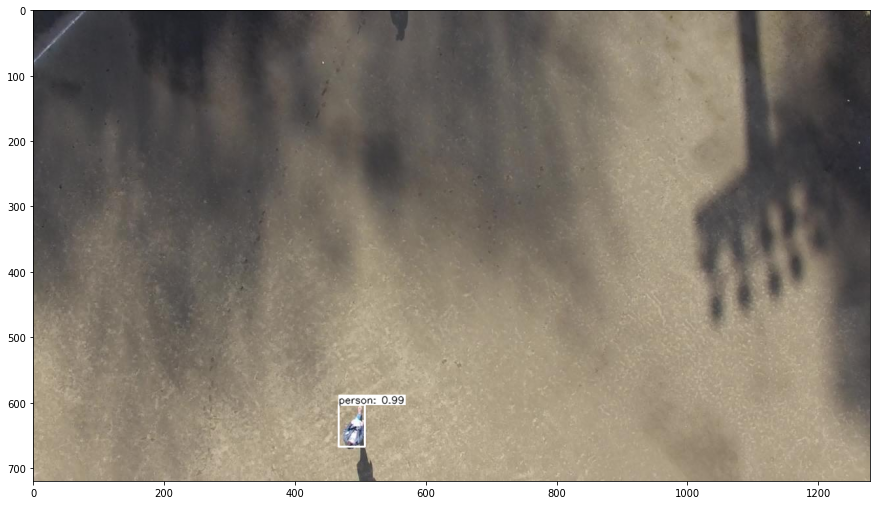

Frame with prediction
Num person detected: 1


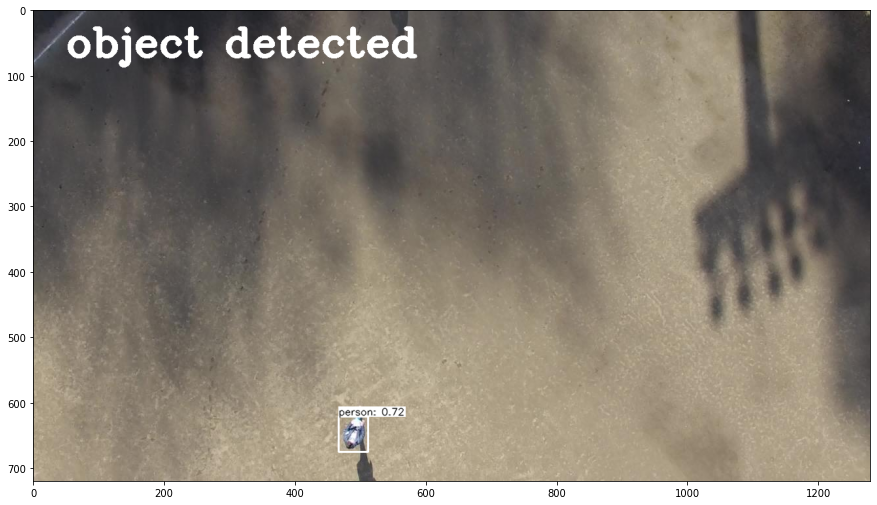

In [29]:
idx = np.random.randint(len(frames))
image_path2 = frames[idx]
print(idx, ':', image_path2)

print('Frame with true bboxes')
res = utils.frame_with_true_bboxes(image_path2, labels)
fig, ax = plt.subplots(figsize=(15,22))
plt.imshow(res)
plt.show()

print('Frame with prediction')
frame = cv2.imread(image_path2)
out_new = utils.predict_on_frame(frame, model, threshold=0.1)
fig, ax = plt.subplots(figsize=(15,22))
plt.imshow(out_new)
plt.show()

In [162]:
def yolo_loss(y_true, y_pred):
    '''Return yolo_loss tensor
    
    Parameters
    ----------
    y_true: tensor, shape(m, grid_size, grid_size, 3, 85)
        the output of preprocess_true_boxes
    y_pred: tensor, shape(m, grid_size, grid_size, 3, 85)
        the prediction of an output layer
    l: int
        2 ==> 52x52 output layer
        1 ==> 26x26 output layer
        0 ==> 13x13 output layer
    
    Returns
    -------
    loss: tensor, shape=(1,)
    '''
    print_loss = False
    
    # Number of data
    m = K.shape(y_pred)[0]
    mf = K.cast(m, K.dtype(y_pred)) 
    
    y_true_xy = y_true[...,0:2]
    y_pred_xy = y_pred[...,0:2]
    y_true_wh = y_true[...,2:4]
    y_pred_wh = y_pred[...,2:4]
    y_true_conf = y_true[...,4]
    y_pred_conf = y_pred[...,4]
    
    object_mask = y_true[..., 4:5] # Contains 0. or 1. values : if 0. then there is no objects on the cell

    # Compute iou    
    intersect_wh = K.maximum(
        K.zeros_like(y_pred_wh), (y_pred_wh + y_true_wh)/2 - K.abs(y_pred_xy - y_true_xy) 
    )
    intersect_area = intersect_wh[...,0] * intersect_wh[...,1]
    true_area = y_true_wh[...,0] * y_true_wh[...,1]
    pred_area = y_pred_wh[...,0] * y_pred_wh[...,1]
    union_area = pred_area + true_area - intersect_area
    iou = intersect_area / union_area
    
    obj_loss = (
        K.binary_crossentropy(y_true_conf, y_pred_conf, from_logits=True)
    )
    
    # K.binary_crossentropy is helpful to avoid exp overflow
    xy_loss = (
        object_mask
        * K.binary_crossentropy(
            tf.sigmoid(y_true_xy), 
            tf.sigmoid(y_pred_xy), from_logits=True)
    )
    
    wh_loss = (
        object_mask
        * K.square(K.sqrt(y_true[..., 2:4]) - K.sqrt(y_pred[..., 2:4]))
    )
    
    class_loss = (
        object_mask
        * K.square(y_true[..., 5:] - y_pred[..., 5:])
    )

    confidence_loss = (
        K.square(y_true_conf*iou - y_pred_conf)*y_true_conf
    ) 
    
    obj_loss = K.sum(obj_loss) / mf
    xy_loss = K.sum(xy_loss) / mf
    wh_loss = K.sum(wh_loss) / mf
    confidence_loss = K.sum(confidence_loss) / mf
    class_loss = K.sum(class_loss) / mf
    
    loss = obj_loss + xy_loss + wh_loss + confidence_loss + class_loss
    
    if print_loss:        
        tf.print('For output layer %i loss, obj_loss, xy_loss, wh_loss, confidence_loss, class_loss is :'%(l))
        tf.print(loss)
        tf.print(obj_loss)
        tf.print(xy_loss)
        tf.print(wh_loss)
        tf.print(confidence_loss)
        tf.print(class_loss)
        
    return loss